# Deep Learning
## Practice Projects
# P2: Multi-Label Classification

## Step 0. Style and Libraries

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


In [3]:
hide_code
# Plot the Neural network fitting history
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## Step 1. Load and Explore the Data
Run the following cell to download the dataset.

In [4]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/" + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("data/letters.csv")
files = data['file']
letters = data['letter']
backgrounds = data['background']
targets = data['label'].as_matrix()
tensors = data_to_tensor(files);

100%|██████████| 1650/1650 [00:25<00:00, 64.75it/s]


In [5]:
hide_code
# Print the shape 
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)


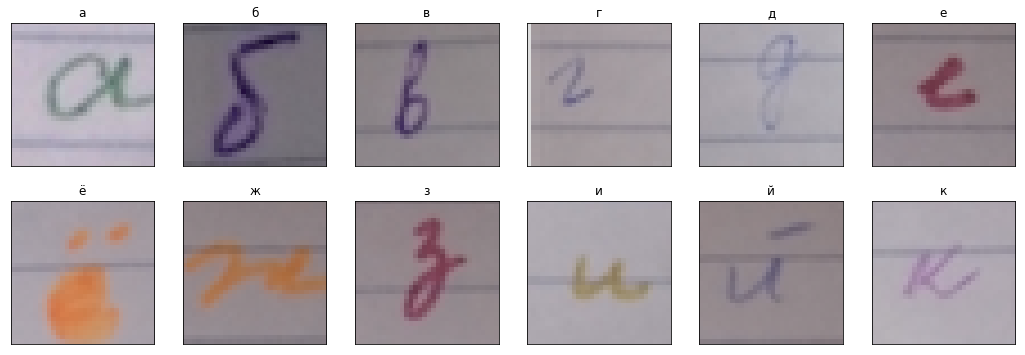

In [6]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*50])
    display_images(files[i*50], ax)

## Step 2. Save and Load the Data¶
The data tensors can be saved in the appropriate format of files .h5.

In [7]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.create_dataset('backgrounds', data = backgrounds)
    f.close()

In [8]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [9]:
hide_code
# Create tensors and targets
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [10]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  в


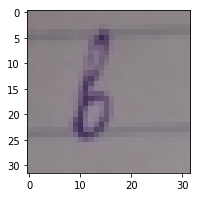

In [11]:
hide_code
# Read and display a tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(tensors[100]);

Create tensors of grayscaled images and display their shape.

In [12]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (1650, 32, 32)


Label:  в


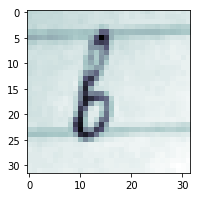

In [13]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[100], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [14]:
hide_code
# Print the target unique values
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [15]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(1650, 33)

In [16]:
hide_code
# One-hot encode the background targets
backgrounds = to_categorical(backgrounds, 2)
backgrounds.shape

(1650, 2)

### Add background

In [17]:
hide_code
# Create multi-label targets
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(1650, 35)

### Split
#### Color Images
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 20%.

In [18]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [19]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (1320, 32, 32, 3)
Training target's shape (1320, 33)
Testing tensor's shape: (330, 32, 32, 3)
Testing target's shape (330, 33)


#### Grayscaled Images

In [20]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [21]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2 = x_train2.reshape(-1, 32, 32, 1), x_test2.reshape(-1, 32, 32, 1)

In [22]:
hide_code
# Print the shape
print ("Training grayscaled tensor's shape:", x_train2.shape)
print ("Training grayscaled target's shape", y_train2.shape)
print ("Testing grayscaled tensor's shape:", x_test2.shape)
print ("Testing grayscaled target's shape", y_test2.shape)

Training grayscaled tensor's shape: (1320, 32, 32, 1)
Training grayscaled target's shape (1320, 33)
Testing grayscaled tensor's shape: (330, 32, 32, 1)
Testing grayscaled target's shape (330, 33)


In [23]:
hide_code
# Convert images from grayscaled to RGB
x_train2_tensor = tf.image.grayscale_to_rgb(x_train2, name=None)
x_test2_tensor = tf.image.grayscale_to_rgb(x_test2, name=None)
# Run tensorflow session
sess = tf.Session()
with sess.as_default():
    x_train2_color = x_train2_tensor.eval()
    x_test2_color = x_test2_tensor.eval()
# Check the shape    
x_train2_color.shape, x_test2_color.shape

((1320, 32, 32, 3), (330, 32, 32, 3))

#### Multi-label targets, color images

In [24]:
hide_code
# Split with multi-label targets
x_train3, x_test3, y_train3, y_test3 = train_test_split(tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [25]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train3.shape)
print ("Training target's shape", y_train3.shape)
print ("Testing tensor's shape:", x_test3.shape)
print ("Testing target's shape", y_test3.shape)

Training tensor's shape: (1320, 32, 32, 3)
Training target's shape (1320, 35)
Testing tensor's shape: (330, 32, 32, 3)
Testing target's shape (330, 35)


In [26]:
hide_code
# Create a list of targets
y_train3_list = [y_train3[:, :33], y_train3[:, 33:]]
y_test3_list = [y_test3[:, :33], y_test3[:, 33:]]

#### Multi-label targets, grayscaled images

In [27]:
hide_code
# Split the grayscaled data
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [28]:
hide_code
# Reshape the grayscaled data
x_train4, x_test4 = x_train4.reshape(-1, 32, 32, 1), x_test4.reshape(-1, 32, 32, 1)

In [29]:
hide_code
# Print the shape
print ("Training grayscaled tensor's shape:", x_train4.shape)
print ("Training grayscaled target's shape", y_train4.shape)
print ("Testing grayscaled tensor's shape:", x_test4.shape)
print ("Testing grayscaled target's shape", y_test4.shape)

Training grayscaled tensor's shape: (1320, 32, 32, 1)
Training grayscaled target's shape (1320, 35)
Testing grayscaled tensor's shape: (330, 32, 32, 1)
Testing grayscaled target's shape (330, 35)


In [30]:
hide_code
# Create a list of targets
y_train4_list = [y_train4[:, :33], y_train4[:, 33:]]
y_test4_list = [y_test4[:, :33], y_test4[:, 33:]]

## Step 4. Create a One-Label Classification Model
### Color Images
Define a model architecture and compile the model for color images.

In [30]:
hide_code
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

model = model()

In [31]:
hide_code
# Train the model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer])

Train on 1320 samples, validate on 330 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 3.49799, saving model to weights.best.model.hdf5
18s - loss: 3.5029 - acc: 0.0341 - val_loss: 3.4980 - val_acc: 0.0182
Epoch 2/100
Epoch 00001: val_loss did not improve
7s - loss: 3.4956 - acc: 0.0326 - val_loss: 3.4993 - val_acc: 0.0212
Epoch 3/100
Epoch 00002: val_loss improved from 3.49799 to 3.48532, saving model to weights.best.model.hdf5
8s - loss: 3.4916 - acc: 0.0379 - val_loss: 3.4853 - val_acc: 0.0394
Epoch 4/100
Epoch 00003: val_loss did not improve
7s - loss: 3.4790 - acc: 0.0409 - val_loss: 3.4867 - val_acc: 0.0455
Epoch 5/100
Epoch 00004: val_loss improved from 3.48532 to 3.45801, saving model to weights.best.model.hdf5
8s - loss: 3.4645 - acc: 0.0424 - val_loss: 3.4580 - val_acc: 0.0424
Epoch 6/100
Epoch 00005: val_loss did not improve
7s - loss: 3.4539 - acc: 0.0439 - val_loss: 3.4637 - val_acc: 0.0455
Epoch 7/100
Epoch 00006: val_loss improved from 3.45801 to 3.45095, 

Epoch 00062: val_loss did not improve
7s - loss: 3.1816 - acc: 0.1038 - val_loss: 3.8300 - val_acc: 0.0364
Epoch 64/100
Epoch 00063: val_loss did not improve
7s - loss: 3.1889 - acc: 0.1030 - val_loss: 3.7180 - val_acc: 0.0364
Epoch 65/100
Epoch 00064: val_loss did not improve
7s - loss: 3.1663 - acc: 0.0985 - val_loss: 3.6451 - val_acc: 0.0515
Epoch 66/100
Epoch 00065: val_loss did not improve
7s - loss: 3.1681 - acc: 0.1015 - val_loss: 3.7259 - val_acc: 0.0455
Epoch 67/100
Epoch 00066: val_loss did not improve
7s - loss: 3.1550 - acc: 0.0917 - val_loss: 3.5838 - val_acc: 0.0485
Epoch 68/100
Epoch 00067: val_loss did not improve
8s - loss: 3.1720 - acc: 0.0924 - val_loss: 3.6701 - val_acc: 0.0606
Epoch 69/100
Epoch 00068: val_loss did not improve
7s - loss: 3.1497 - acc: 0.1106 - val_loss: 3.7259 - val_acc: 0.0424
Epoch 70/100
Epoch 00069: val_loss did not improve
7s - loss: 3.1303 - acc: 0.1061 - val_loss: 3.5562 - val_acc: 0.0606
Epoch 71/100
Epoch 00070: val_loss did not improve
7s

We should have an accuracy greater than 3%

In [32]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

320/330 [============================>.] - ETA: 0s

[3.307119437420007, 0.069696969696969702]

Apply the ImageDataGenerator() function.

In [39]:
hide_code
# Fit the model with ImageDataGenerator()
steps, epochs = 1000, 5
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

generator = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                steps_per_epoch = steps, epochs = epochs,
                                validation_data = (x_test, y_test), 
                                callbacks=[checkpointer], verbose=2)

Epoch 1/5
Epoch 00000: val_loss did not improve
280s - loss: 3.1527 - acc: 0.1002 - val_loss: 3.4413 - val_acc: 0.0667
Epoch 2/5
Epoch 00001: val_loss did not improve
276s - loss: 2.9898 - acc: 0.1234 - val_loss: 3.8741 - val_acc: 0.0788
Epoch 3/5
Epoch 00002: val_loss did not improve
276s - loss: 2.8761 - acc: 0.1392 - val_loss: 3.8046 - val_acc: 0.0727
Epoch 4/5
Epoch 00003: val_loss did not improve
302s - loss: 2.8007 - acc: 0.1497 - val_loss: 4.2373 - val_acc: 0.0667
Epoch 5/5
Epoch 00004: val_loss did not improve
317s - loss: 2.7512 - acc: 0.1575 - val_loss: 4.2089 - val_acc: 0.0515


In [79]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

320/330 [============================>.] - ETA: 0s

[3.2676794456713125, 0.093939393939393934]

Let's compare the results with classifying algorithms.

In [41]:
hide_code
# Fit the classifier and get the accuracy score
y_train_c = np.array([np.argmax(y) for y in y_train])
y_test_c = np.array([np.argmax(y) for y in y_test])
clf = GradientBoostingClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.11212121212121212

In [42]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf2.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.10606060606060606

### Grayscaled Images

In [31]:
hide_code
def gray_model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

gray_model = gray_model()

In [32]:
hide_code
# Train the model
gray_checkpointer = ModelCheckpoint(filepath='weights.best.gray_model.hdf5', 
                                    verbose=2, save_best_only=True)
gray_history = gray_model.fit(x_train2, y_train2, 
                              epochs=300, batch_size=64, verbose=0,
                              validation_data=(x_test2, y_test2),
                              callbacks=[gray_checkpointer])

Epoch 00000: val_loss improved from inf to 3.49684, saving model to weights.best.gray_model.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 3.49684 to 3.48483, saving model to weights.best.gray_model.hdf5
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved from 3.48483 to 3.47631, saving model to weights.best.gray_model.hdf5
Epoch 00015: val_loss improved from 3.47631 to 3.47194, saving model to weights.best.gray_model.hdf5
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss improved from 3.47194 to 3.45470, saving model

Epoch 00161: val_loss did not improve
Epoch 00162: val_loss did not improve
Epoch 00163: val_loss did not improve
Epoch 00164: val_loss improved from 2.17450 to 2.04905, saving model to weights.best.gray_model.hdf5
Epoch 00165: val_loss did not improve
Epoch 00166: val_loss did not improve
Epoch 00167: val_loss did not improve
Epoch 00168: val_loss did not improve
Epoch 00169: val_loss did not improve
Epoch 00170: val_loss did not improve
Epoch 00171: val_loss did not improve
Epoch 00172: val_loss did not improve
Epoch 00173: val_loss did not improve
Epoch 00174: val_loss did not improve
Epoch 00175: val_loss did not improve
Epoch 00176: val_loss did not improve
Epoch 00177: val_loss did not improve
Epoch 00178: val_loss improved from 2.04905 to 2.02703, saving model to weights.best.gray_model.hdf5
Epoch 00179: val_loss improved from 2.02703 to 1.95390, saving model to weights.best.gray_model.hdf5
Epoch 00180: val_loss did not improve
Epoch 00181: val_loss did not improve
Epoch 00182: 

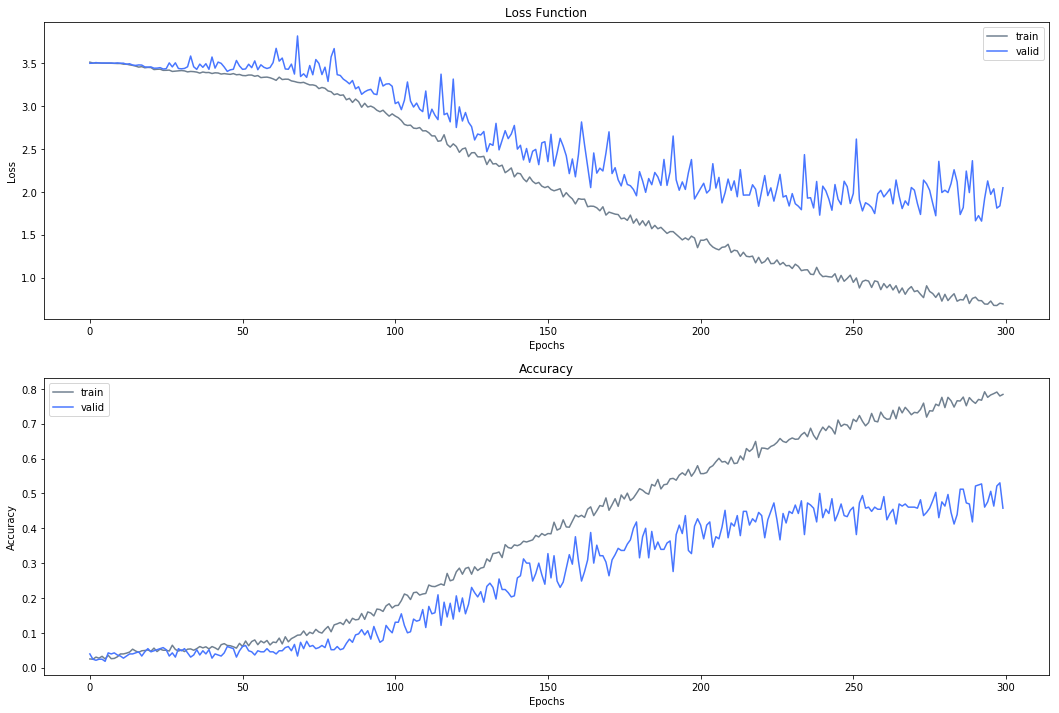

In [33]:
hide_code
# Plot the training history
history_plot(gray_history, 0)

Try to reach an accuracy greater than 50%

In [34]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

320/330 [============================>.] - ETA: 0s

[1.6584858695665996, 0.5272727276339676]

Apply the ImageDataGenerator() function.

In [35]:
hide_code
# Fit the model with ImageDataGenerator()
steps, epochs = 1000, 10
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

gray_generator = gray_model.fit_generator(data_generator.flow(x_train2, y_train2, batch_size=64),
                                          steps_per_epoch = steps, epochs = epochs,
                                          validation_data = (x_test2, y_test2), 
                                          callbacks=[gray_checkpointer], verbose=2)

Epoch 1/10
Epoch 00000: val_loss improved from 1.65849 to 1.61704, saving model to weights.best.gray_model.hdf5
539s - loss: 1.7989 - acc: 0.4846 - val_loss: 1.6170 - val_acc: 0.4970
Epoch 2/10
Epoch 00001: val_loss improved from 1.61704 to 1.49087, saving model to weights.best.gray_model.hdf5
529s - loss: 1.5761 - acc: 0.5403 - val_loss: 1.4909 - val_acc: 0.5424
Epoch 3/10
Epoch 00002: val_loss improved from 1.49087 to 1.47926, saving model to weights.best.gray_model.hdf5
529s - loss: 1.4361 - acc: 0.5791 - val_loss: 1.4793 - val_acc: 0.5485
Epoch 4/10
Epoch 00003: val_loss did not improve
529s - loss: 1.3386 - acc: 0.6084 - val_loss: 1.5858 - val_acc: 0.5636
Epoch 5/10
Epoch 00004: val_loss improved from 1.47926 to 1.40497, saving model to weights.best.gray_model.hdf5
529s - loss: 1.2518 - acc: 0.6373 - val_loss: 1.4050 - val_acc: 0.6000
Epoch 6/10
Epoch 00005: val_loss did not improve
538s - loss: 1.2094 - acc: 0.6506 - val_loss: 1.9211 - val_acc: 0.5152
Epoch 7/10
Epoch 00006: val_

In [36]:
hide_code
# Load the model with the best validation accuracy
gray_model.load_weights('weights.best.gray_model.hdf5')
# Calculate classification accuracy on the testing set
gray_score = gray_model.evaluate(x_test2, y_test2)
gray_score

320/330 [============================>.] - ETA: 0s

[1.4049676747033091, 0.59999999927751946]

Let's compare the results with classifying algorithms.

In [80]:
hide_code
# Fit the classifier and get the accuracy score
y_train2_c = np.array([np.argmax(y) for y in y_train2])
y_test2_c = np.array([np.argmax(y) for y in y_test2])
clf = GradientBoostingClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.081818181818181818

In [81]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train2.reshape(-1, 32*32), y_train2_c)
clf2.score(x_test2.reshape(-1, 32*32), y_test2_c)

0.087878787878787876

## Step 5. Create a Multi-Label Classification Model
### Color Images

In [183]:
hide_code
def multi_model():    
    model_input = Input(shape=(32, 32, 3))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
        
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Dense(128, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [184]:
hide_code
# Display the model architecture
multi_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_61 (Conv2D)               (None, 32, 32, 32)    896         input_11[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_61 (MaxPooling2D)  (None, 16, 16, 32)    0           conv2d_61[0][0]                  
____________________________________________________________________________________________________
dropout_121 (Dropout)            (None, 16, 16, 32)    0           max_pooling2d_61[0][0]           
___________________________________________________________________________________________

In [185]:
hide_code
# Train the model
multi_checkpointer = ModelCheckpoint(filepath='weights.best.multi.hdf5', 
                                     verbose=2, save_best_only=True)
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_test3, y_test3_list), 
                                epochs=50, batch_size=64, verbose=0, 
                                callbacks=[multi_checkpointer])

Epoch 00000: val_loss improved from inf to 4.18444, saving model to weights.best.multi.hdf5
Epoch 00001: val_loss improved from 4.18444 to 4.18439, saving model to weights.best.multi.hdf5
Epoch 00002: val_loss improved from 4.18439 to 4.18302, saving model to weights.best.multi.hdf5
Epoch 00003: val_loss improved from 4.18302 to 4.17711, saving model to weights.best.multi.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 4.17711 to 4.04847, saving model to weights.best.multi.hdf5
Epoch 00010: val_loss improved from 4.04847 to 4.02744, saving model to weights.best.multi.hdf5
Epoch 00011: val_loss improved from 4.02744 to 3.96499, saving model to weights.best.multi.hdf5
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved from 3.96499 to 3.90728, saving mod

We should have an accuracy greater than 3% for the first target (letter) and greater than 50% for the second target (background).

In [186]:
hide_code
# Load the model with the best validation accuracy
multi_model.load_weights('weights.best.multi.hdf5')
# Calculate classification accuracy on the testing set
multi_scores = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_scores))
print("First label. Accuracy: %.2f%%" % (multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_scores[4]*100))

Scores: 
 [3.4784907254305755, 3.0530445474566834, 0.42544620904055508, 0.093939393939393934, 0.8181818174593376]
First label. Accuracy: 9.39%
Second label. Accuracy: 81.82%


### Grayscaled Images

In [197]:
hide_code
def gray_multi_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
    # TODO: Define a model architecture
        
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)       
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(1024, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Dense(256, activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    y1 = Dense(33, activation='softmax')(x)
    y2 = Dense(2, activation='softmax')(x)
    
    # TODO: Compile the model    
    model = Model(inputs=model_input, outputs=[y1, y2])

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

gray_multi_model = gray_multi_model()

In [198]:
hide_code
# Train the model
gray_multi_checkpointer = ModelCheckpoint(filepath='weights.best.gray_multi.hdf5', 
                                          verbose=2, save_best_only=True)
gray_multi_history = gray_multi_model.fit(x_train4, y_train4_list, 
                                          validation_data=(x_test4, y_test4_list), 
                                          epochs=50, batch_size=64, verbose=0, 
                                          callbacks=[gray_multi_checkpointer])

Epoch 00000: val_loss improved from inf to 4.18728, saving model to weights.best.gray_multi.hdf5
Epoch 00001: val_loss improved from 4.18728 to 4.18499, saving model to weights.best.gray_multi.hdf5
Epoch 00002: val_loss improved from 4.18499 to 4.18078, saving model to weights.best.gray_multi.hdf5
Epoch 00003: val_loss improved from 4.18078 to 4.17840, saving model to weights.best.gray_multi.hdf5
Epoch 00004: val_loss improved from 4.17840 to 4.16827, saving model to weights.best.gray_multi.hdf5
Epoch 00005: val_loss improved from 4.16827 to 4.16135, saving model to weights.best.gray_multi.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 4.16135 to 4.14561, saving model to weights.best.gray_multi.hdf5
Epoch 00009: val_loss improved from 4.14561 to 4.13014, saving model to weights.best.gray_multi.hdf5
Epoch 00010: val_loss improved from 4.13014 to 4.12216, saving model to weights.best.gray_multi.hdf5
Epoch 00011: val_lo

We should have an accuracy greater than 3% for the first target (letter) and greater than 50% for the second target (background).

In [199]:
hide_code
# Load the model with the best validation accuracy
gray_multi_model.load_weights('weights.best.gray_multi.hdf5')
# Calculate classification accuracy on the testing set
gray_multi_scores = gray_multi_model.evaluate(x_test4, y_test4_list, verbose=0)

print("Scores: \n" , (gray_multi_scores))
print("First label. Accuracy: %.2f%%" % (gray_multi_scores[3]*100))
print("Second label. Accuracy: %.2f%%" % (gray_multi_scores[4]*100))

Scores: 
 [4.0780166568178116, 3.426785522518736, 0.65123110359365288, 0.048484848484848485, 0.60909090872966887]
First label. Accuracy: 4.85%
Second label. Accuracy: 60.91%


## Step 6. Keras Applications
Choose one of the keras applications and try to reach an accuracy greater than 30%
### Color Images

In [33]:
# Create bottleneck features
resize_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                           for i in range(0, len(x_train))]).astype('float32')
resize_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                          for i in range(0, len(x_test))]).astype('float32')
iv3_x_train = preprocess_input(resize_x_train)
iv3_x_test = preprocess_input(resize_x_test)
iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x_train_bn = iv3_base_model.predict(iv3_x_train)
x_test_bn = iv3_base_model.predict(iv3_x_test)

In [34]:
# Save bottleneck features
x_train_bn = np.squeeze(x_train_bn)
x_test_bn = np.squeeze(x_test_bn)
np.save('x_train_bn.npy', x_train_bn)
np.save('x_test_bn.npy', x_test_bn)

In [35]:
# Load bottleneck features
x_train_bn = np.load('x_train_bn.npy')
x_test_bn = np.load('x_test_bn.npy')

In [270]:
hide_code
def iv3_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    # TODO: Compile the model     
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

iv3_model = iv3_model()

In [271]:
hide_code
# Fit the model 
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3.hdf5', 
                                     verbose=2, save_best_only=True)
iv3_history = iv3_model.fit(x_train_bn, y_train, 
                            validation_data=(x_test_bn, y_test),
                            epochs=50, batch_size=64, 
                            callbacks=[iv3_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 3.67129, saving model to weights.best.iv3.hdf5
Epoch 00001: val_loss improved from 3.67129 to 3.21915, saving model to weights.best.iv3.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 3.21915 to 2.83821, saving model to weights.best.iv3.hdf5
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 2.83821 to 2.81490, saving model to weights.best.iv3.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 2.81490 to 2.80183, saving model to weights.best.iv3.hdf5
Epoch 00009: val_loss improved from 2.80183 to 2.73322, saving model to weights.best.iv3.hdf5
Epoch 00010: val_loss improved from 2.73322 to 2.40326, saving model to weights.best.iv3.hdf5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoc

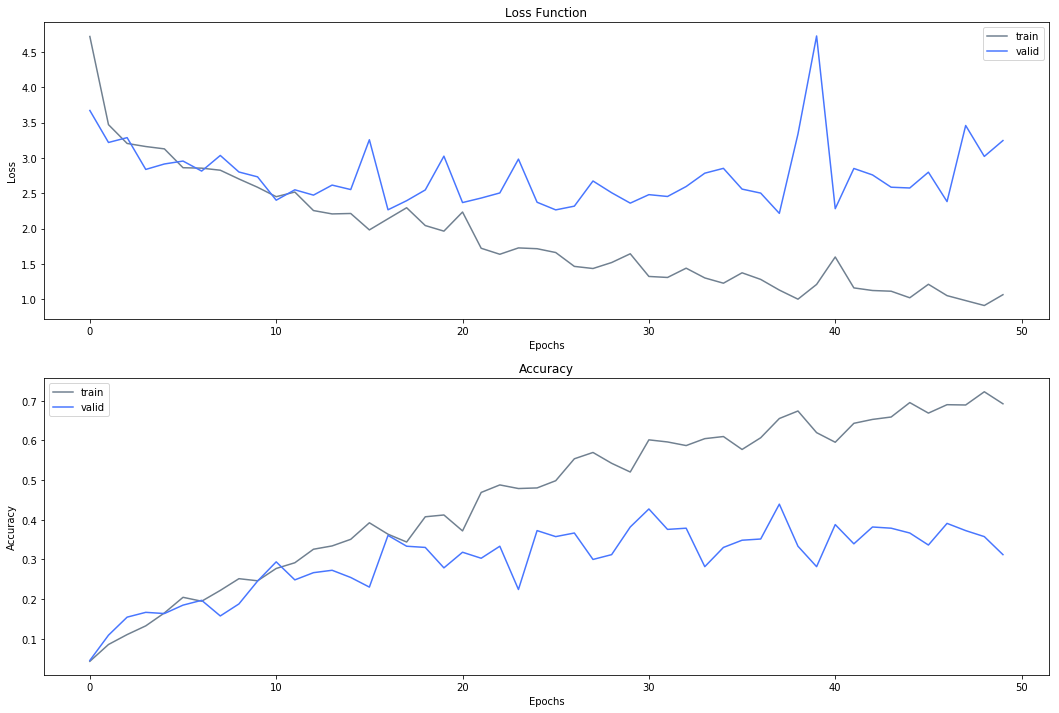

In [272]:
hide_code
# Plot the training history
history_plot(iv3_history, 0)

In [273]:
hide_code
# Load the model with the best validation accuracy
iv3_model.load_weights('weights.best.iv3.hdf5')
# Calculate classification accuracy on the testing set
iv3_scores = iv3_model.evaluate(x_test_bn, y_test)
print("Accuracy: %.2f%%" % (iv3_scores[1]*100))
iv3_scores

320/330 [============================>.] - ETA: 0sAccuracy: 43.94%


[2.2173518325343275, 0.43939393903269913]

### Grayscaled Images

In [226]:
# Create bottleneck features
resize_x_train2 = np.array([scipy.misc.imresize(x_train2_color[i], (139, 139, 3)) 
                            for i in range(0, len(x_train2_color))]).astype('float32')
resize_x_test2 = np.array([scipy.misc.imresize(x_test2_color[i], (139, 139, 3)) 
                           for i in range(0, len(x_test2_color))]).astype('float32')
iv3_x_train2 = preprocess_input(resize_x_train2)
iv3_x_test2 = preprocess_input(resize_x_test2)
iv3_base_model2 = InceptionV3(weights='imagenet', include_top=False)
x_train_bn2 = iv3_base_model2.predict(iv3_x_train2)
x_test_bn2 = iv3_base_model2.predict(iv3_x_test2)

In [227]:
# Save bottleneck features
x_train_bn2 = np.squeeze(x_train_bn2)
x_test_bn2 = np.squeeze(x_test_bn2)
np.save('x_train_bn2.npy', x_train_bn2)
np.save('x_test_bn2.npy', x_test_bn2)

In [228]:
# Load bottleneck features
x_train_bn2 = np.load('x_train_bn2.npy')
x_test_bn2 = np.load('x_test_bn2.npy')

In [262]:
hide_code
def iv3_gray_model():
    model = Sequential()
    # TODO: Define a model architecture
    model.add(Conv2D(filters=32, kernel_size=2, input_shape=x_train_bn2.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
        
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(33, activation='softmax'))
    # TODO: Compile the model     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

iv3_gray_model = iv3_gray_model()

In [263]:
hide_code
# Fit the model 
iv3_gray_checkpointer = ModelCheckpoint(filepath='weights.best.iv3_gray.hdf5', 
                                        verbose=2, save_best_only=True)
iv3_gray_history = iv3_gray_model.fit(x_train_bn2, y_train2, 
                                      validation_data=(x_test_bn2, y_test2),
                                      epochs=50, batch_size=64, 
                                      callbacks=[iv3_gray_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 3.45489, saving model to weights.best.iv3_gray.hdf5
Epoch 00001: val_loss improved from 3.45489 to 3.25901, saving model to weights.best.iv3_gray.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss improved from 3.25901 to 2.95905, saving model to weights.best.iv3_gray.hdf5
Epoch 00004: val_loss improved from 2.95905 to 2.77506, saving model to weights.best.iv3_gray.hdf5
Epoch 00005: val_loss improved from 2.77506 to 2.69466, saving model to weights.best.iv3_gray.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 2.69466 to 2.52928, saving model to weights.best.iv3_gray.hdf5
Epoch 00008: val_loss improved from 2.52928 to 2.47701, saving model to weights.best.iv3_gray.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 2.47701 to 2.45250, saving model to weights.best.iv3_gray.hdf5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss improved from 2.45250 to 2.43977, savi

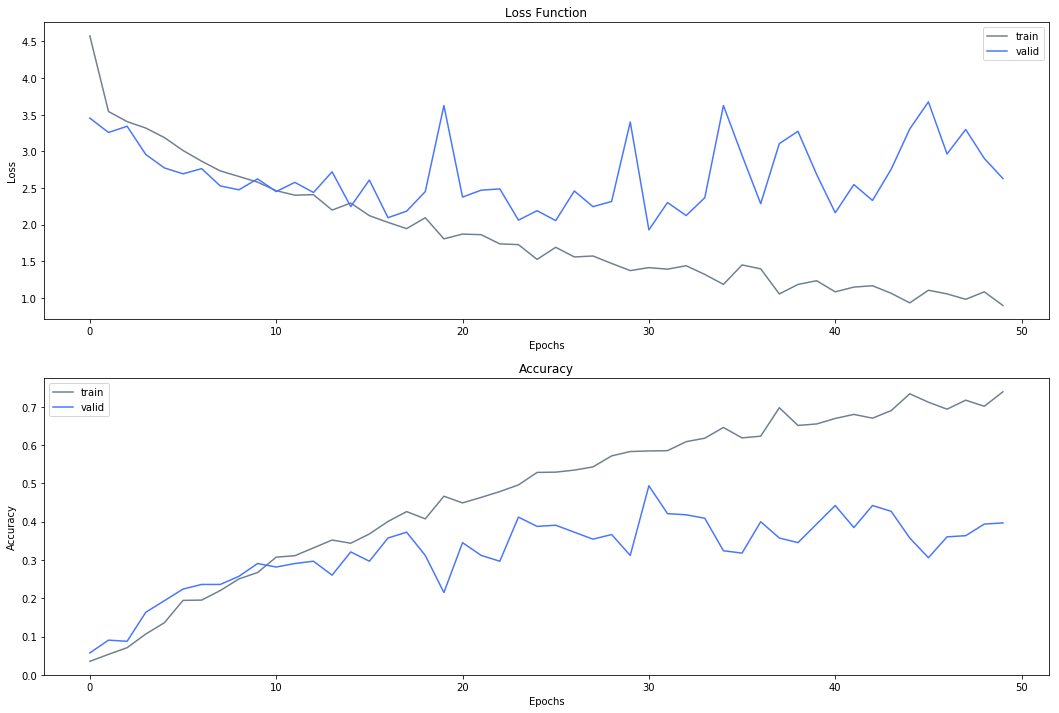

In [264]:
hide_code
# Plot the training history
history_plot(iv3_gray_history, 0)

In [265]:
hide_code
# Load the model with the best validation accuracy
iv3_gray_model.load_weights('weights.best.iv3_gray.hdf5')
# Calculate classification accuracy on the testing set
iv3_gray_scores = iv3_gray_model.evaluate(x_test_bn2, y_test2)
print("Accuracy: %.2f%%" % (iv3_gray_scores[1]*100))
iv3_gray_scores

256/330 [======================>.......] - ETA: 0sAccuracy: 49.39%


[1.930430860230417, 0.49393939412001409]

## Step 7. Predictions
Display predictions for the models with the best accuracy.
### Color Images

In [39]:
hide_code
# Create a list of symbols
symbols = ['а','б','в','г','д','е','ё','ж','з','и','й',
           'к','л','м','н','о','п','р','с','т','у','ф',
           'х','ц','ч','ш','щ','ъ','ы','ь','э','ю','я']

In [286]:
hide_code
# Model predictions for the testing dataset
y_test_predict = iv3_model.predict_classes(x_test_bn)

288/330 [=========================>....] - ETA: 0s

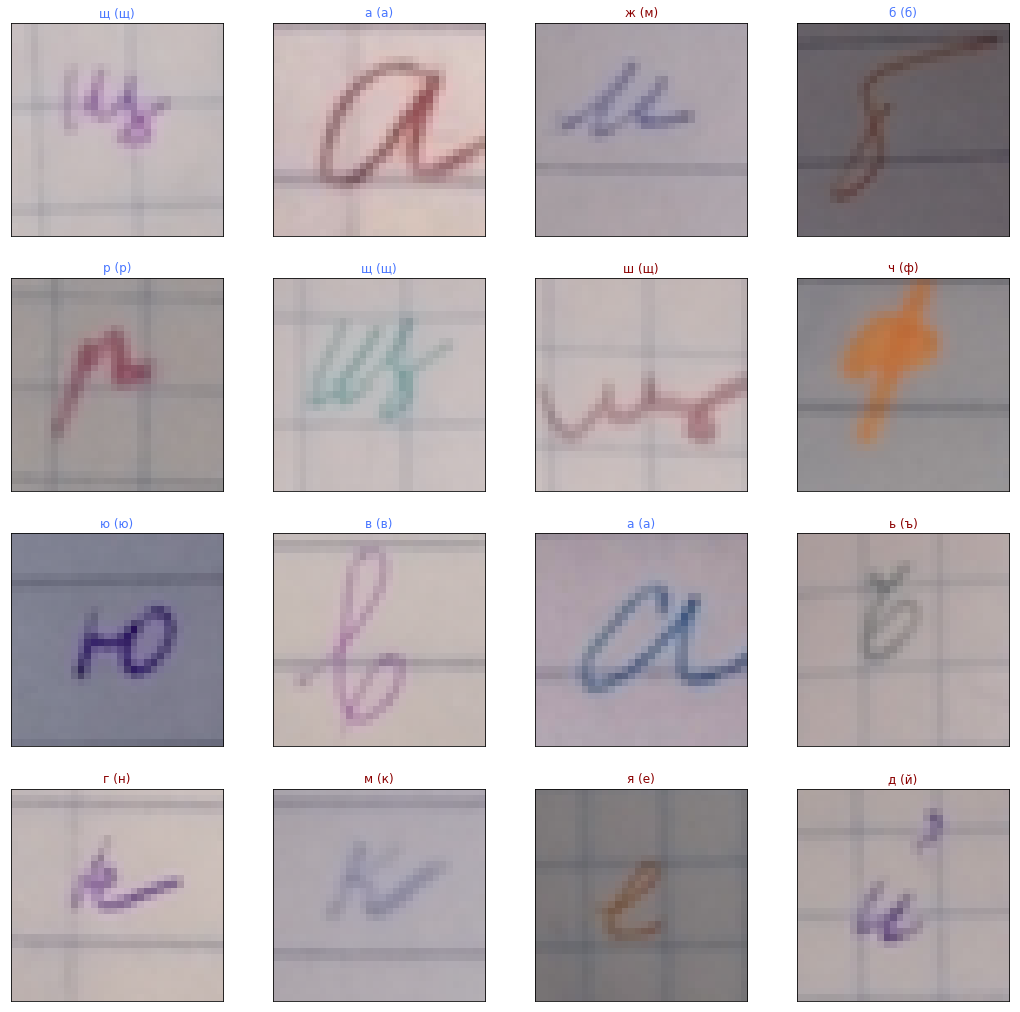

In [287]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

### Grayscaled Images

In [37]:
hide_code
# Model predictions for the testing dataset
y_test2_predict = gray_model.predict_classes(x_test2)

320/330 [============================>.] - ETA: 0s

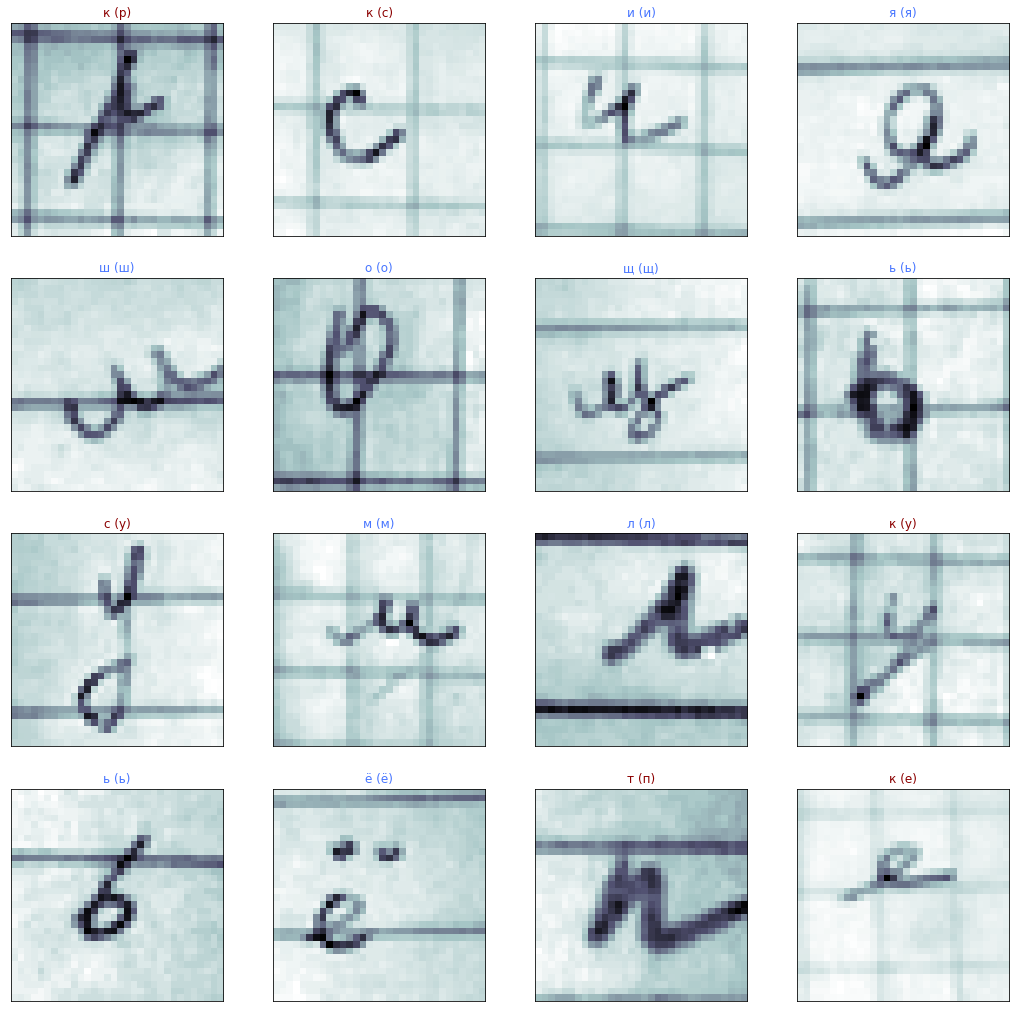

In [41]:
hide_code
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test2.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test2[idx]), cmap=cm.bone)
    pred_idx = y_test2_predict[idx]
    true_idx = np.argmax(y_test2[idx])
    ax.set_title("{} ({})".format(symbols[pred_idx], symbols[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))